## Imports

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import gc
import sys

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, log_loss

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

sys.path.append('/content/drive/My Drive/hse/recsys')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Functions

In [ ]:
def load_data(data_path):
    columns_to_use = ['date_time', 'zone_id', 'banner_id', 'campaign_clicks',
                      'os_id', 'country_id', 'impressions', 'clicks']
    categorical_columns = ['zone_id', 'banner_id', 'os_id',
                           'country_id', 'impressions', 'clicks']
    data = pd.read_csv(data_path,
                       usecols=columns_to_use,
                       parse_dates=['date_time'])
    data[categorical_columns].astype('category')
    return data

In [41]:
def isnull(data):
    print(f'Всего отсутствующих значений: {data.isnull().sum().sum()}')

In [45]:
def datetime_analysis(data):
    fig, ax = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
    axes = ax.ravel()

    xlabels = ['date', 'month', 'hour', 'weekday']
    ylabel = 'observations'
    data.groupby(data.date_time.dt.date).size().plot(kind='bar', ax=axes[0])
    data.groupby(data.date_time.dt.month).size().plot(kind='bar', ax=axes[1])
    data.groupby(data.date_time.dt.hour).size().plot(kind='bar', ax=axes[2])
    data.groupby(data.date_time.dt.weekday).size().plot(kind='bar', ax=axes[3])

    for i, xlabel in enumerate(xlabels):
        axes[i].set_ylabel(ylabel)
        axes[i].set_xlabel(xlabel)
        axes[i].tick_params(labelrotation=30, labelsize='small')

In [47]:
def categorical_analysis(data):
    fig, ax = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
    axes = ax.ravel()

    xlabels = ['os_id', 'country_id', 'banner_id', 'zone_id']
    ylabel = 'observations'

    data.groupby(data.os_id).size().plot(kind='bar', ax=axes[0])
    data.groupby(data.country_id).size().plot(kind='bar', ax=axes[1])
    data.banner_id.plot(kind='hist', ax=axes[2])
    data.zone_id.plot(kind='hist', ax=axes[3])

    for i, xlabel in enumerate(xlabels):
        axes[i].set_ylabel(ylabel)
        axes[i].set_xlabel(xlabel)
        axes[i].tick_params(labelrotation=30, labelsize='small')

In [7]:
def plot_campaign_clicks(data):
    fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
    axes = ax.ravel()
    data.campaign_clicks.plot(kind='hist', ax=axes[0])
    data.campaign_clicks.plot(kind='hist', ax=axes[1], logy=True)

    ax[0].set_xlabel('campaign_clicks')
    ax[1].set_xlabel('campaign_clicks, logy')

In [8]:
def get_interactions(data, interactions_list):
    for col1, col2 in interactions_list:
        data[f'{col1};{col2}'] = data[col1].astype(str) + "_" + data[col2].astype(str)
    return data

In [9]:
def group_categories(data, column_names, threshold):
    for column in column_names:
        new_value = data[column].max() + 1000
        categories_to_group = data[column].value_counts(normalize=True) < threshold
        categories_to_group = categories_to_group[categories_to_group].index
        data.loc[data[column].isin(categories_to_group), column] = new_value
    return data

In [10]:
def feature_engineering(data, interactions):
    # Удалим столбец impressions
    data.drop(['impressions'], axis=1, inplace=True)

    # Временные признаки
    data['hour'] = data.date_time.dt.hour
    data['weekday'] = data.date_time.dt.weekday

    # Группировка редких категорий в banner_id, zone_id
    data = group_categories(data, ['banner_id', 'zone_id'], 0.001)

    # Нормировка campaign_clicks
    data['campaign_clicks'] = np.log1p(data.campaign_clicks)

    # Интеракции
    data = get_interactions(data, interactions)

    return data

In [11]:
def create_dataset(data: pd.DataFrame) -> tuple:
    print('Dataset preparation...')

    # Train-test split
    ts = pd.Timestamp('2021-10-02 00:00:00')
    data.sort_values(by='date_time', inplace=True)
    train_mask, test_mask = data.date_time < ts, data.date_time >= ts
    X_train, X_test = data[train_mask].copy(), data[test_mask].copy()
    y_train, y_test = X_train.clicks.to_numpy(), X_test.clicks.to_numpy()

    columns_names = set(data.columns.to_list())
    columns_names = list(columns_names - {'clicks', 'date_time'})

    columns_to_drop = ['clicks', 'campaign_clicks', 'date_time']
    train_cc = X_train.campaign_clicks.to_numpy()
    test_cc = X_test.campaign_clicks.to_numpy()
    X_train.drop(columns_to_drop, axis=1, inplace=True)
    X_test.drop(columns_to_drop, axis=1, inplace=True)

    del data
    gc.collect()

    # One hot encoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    # Add non-categorical features
    X_train = hstack([X_train, train_cc[:, np.newaxis]])
    X_test = hstack([X_test, test_cc[:, np.newaxis]])

    feature_names = np.hstack((encoder.get_feature_names_out(), ['campaign_clicks']))

    print('Dataset is ready!')

    return X_train, X_test, y_train, y_test, feature_names, columns_names


In [12]:
def create_model(solver='liblinear'):
    return LogisticRegression(solver='liblinear')

In [25]:
def cv(X_train, y_train):
    model = create_model()
    param_search = {'C' : [0.001, 0.01, 0.1, 1.], 'penalty': ['l2']}

    splits = TimeSeriesSplit(n_splits=3)
    clf = GridSearchCV(estimator=model, cv=splits,
                            param_grid=param_search, verbose=10, scoring=['roc_auc', 'neg_log_loss'], refit="neg_log_loss")
    clf.fit(X_train, y_train)
    return clf

In [56]:
def feature_importance(estimator, feature_names, column_names):
    abs_coeffs = np.abs(estimator.coef_)[0]
    feature_importance = {name: 0 for name in column_names}
    cnt = {name: 0 for name in column_names}

    int_flaq_feature = [';' in name for name in feature_names]
    int_flaq_column = [';' in name for name in column_names]

    for i, (feature, coef) in enumerate(zip(feature_names, abs_coeffs)):
      for j, name in enumerate(column_names):
          if feature.startswith(name) and (int_flaq_feature[i] == int_flaq_column[j]):
              feature_importance[name] += np.abs(coef)
              cnt[name] += 1

    for name in column_names:
      feature_importance[name] /= cnt[name]

    return sorted(feature_importance.items(), key=lambda x: -x[1])

## Data analysis

**Этап 1:** загрузим датасет

In [13]:
data_path = '/content/drive/My Drive/hse/recsys/data/data.csv'
data = load_data(data_path)

**Этап 2:** анализ данных

In [14]:
isnull(data)

Всего отсутствующих значений: 0


In [15]:
data.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,15821472.000,15821472.000,15821472.000,15821472.000,15821472.000,15821472.000,15821472.000
mean,81.527,381.648,0.624,1.841,4.347,1.000,0.027
std,163.245,395.939,9.249,1.530,4.318,0.000,0.161
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000
25%,14.000,52.000,0.000,1.000,0.000,1.000,0.000
50%,19.000,217.000,0.000,2.000,4.000,1.000,0.000
75%,60.000,611.000,0.000,3.000,7.000,1.000,0.000
max,3443.000,1632.000,829.000,10.000,16.000,1.000,1.000


Можно увидеть следующие свойства данных:
1. Всего наблюдений - **15 821 472**
2. `impressions` - принимает всего одно значение, поэтому не будем использовать в качестве фичи
3. Столбцы с небольшим количеством категорий - `os_id`, `country_id`
4. Столбцы с большим количеством категорий - `banner_id`, `zone_id` - потенциально в них будем объединять редкие категории

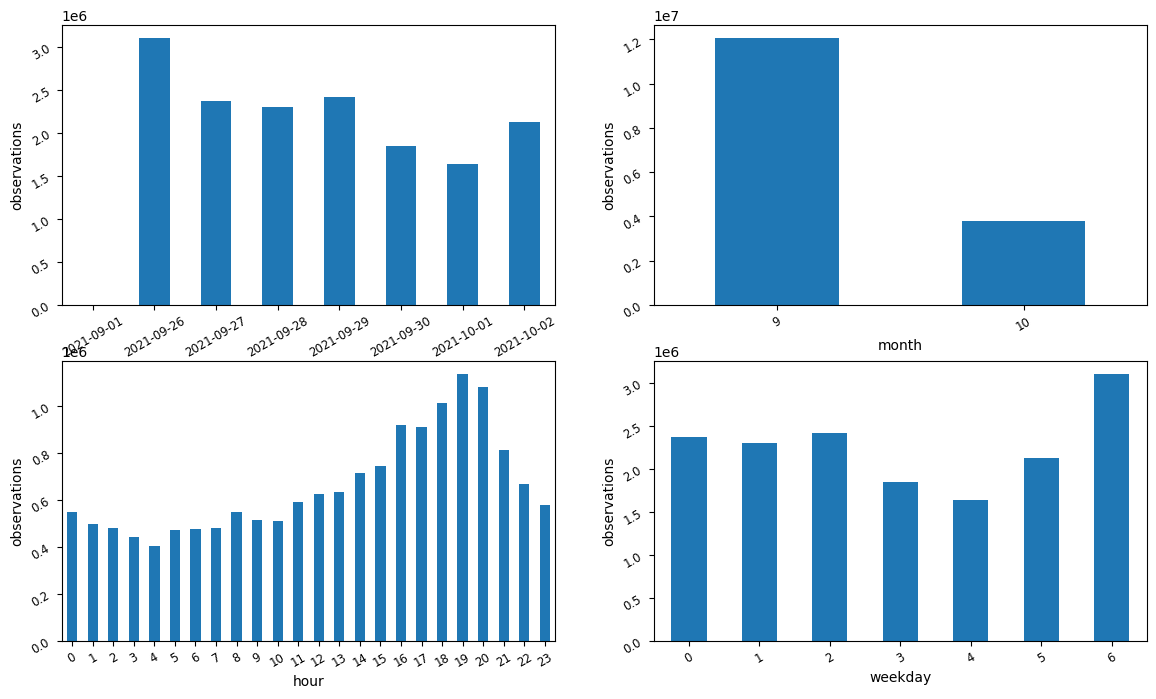

In [16]:
datetime_analysis(data)

*Выводы по datetime данным:*
1. `date` - есть выброс 2021-09-01, необходимо его убрать
2. `hour` и `weekday` - могут быть хорошими фичами, будем добавлять

Давайте посмотрим на распределение категориальных фичей:

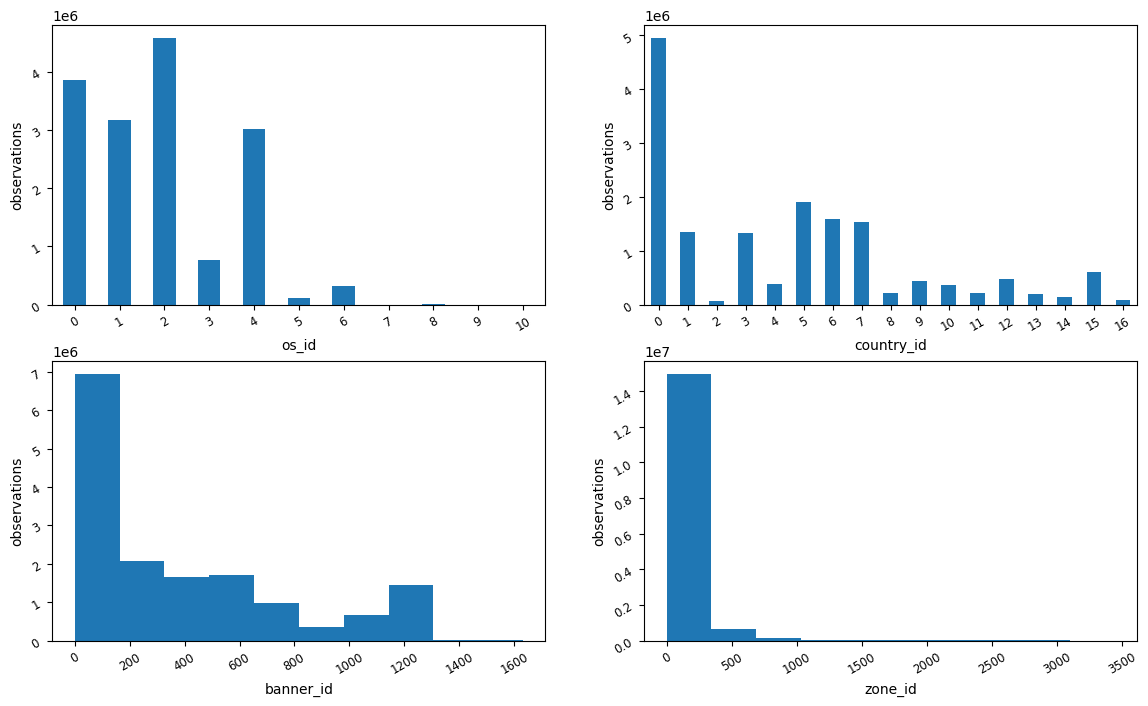

In [17]:
categorical_analysis(data)

Выводы по категориальным данным:
1. `os_id`, `country_id` имеют относительно редкие категории, но так как их мало, то можно и не группировать
2. `banner_id` и `zone_id` - скошенные распределения, будем группировать редкие категории

Распределение `campaign_clicks`

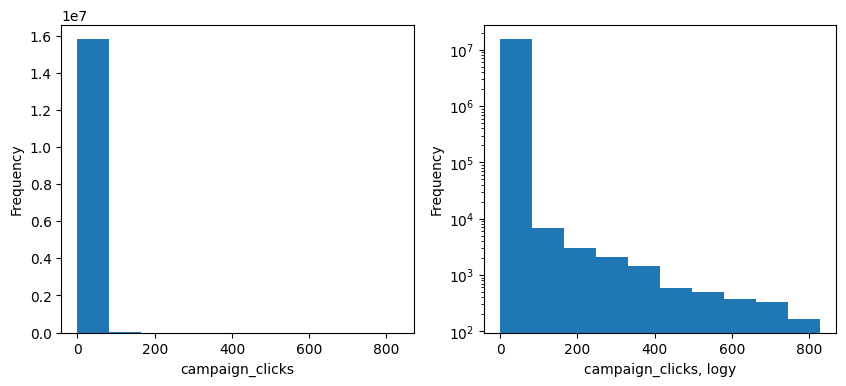

In [18]:
plot_campaign_clicks(data)

Фича имеет сильно скошенное распределение, большинство значений находится в области нуля. Для нормализации будем логарифмировать.

### Feature engineering

***Пояснения к добавлению новых фичей:***
1. `weekday` - день недели - возможно в какие-то дни больше кликов, например, в выходные, когда у людей больше свободного времени
2.  `hour` - час - в какие-то часы дня может быть больше кликов, например, вечером

Оставим пока что столбец `date`, так как он понадобится для разделения на тренировочную и тестовую части

***Что я решила не добавлять в качестве отдельных фичей:***
1. минуты и секунды - скорее всего данные фичи внесут в модель только шум, у нас здесь не высокочастотная торговля
2. год - он один и тот же для всех наблюдений
3. месяц - всего 2 уникальных значения

***Что делаем с banner_id и zone_id:***\
Будем говорить, что категория редкая, если она составляет менее 0.01% от общего числа наблюдений. Объединим редкие категории.

In [19]:
print(f'Количество популярных баннеров: {(data.banner_id.value_counts(normalize=True) >= 0.001).sum()}')
print(f'Количество популярных зон: {(data.zone_id.value_counts(normalize=True) >= 0.001).sum()}')

Количество популярных баннеров: 199
Количество популярных зон: 99


**Интеракции:**
Добавляем  с помощью разделения строковых представлений соответствующих фичей с помощью ;
1. `banner_id`, `zone_id` - в каких-то зонах баннер может быть более привлекательным
2. `banner_id`, `os_id` - какие-то баннеры чаще кликают на конкретных устройствах
3. `banner_id`, `country_id` - в каких-то странах конкретные баннеры просматриваются лучше
4. `banner_id`, `hour` - в разное время дня интересна разная реклама
5. `os_id`, `hour` - в разное время люди используют разные устройства (например, перед работой в дороге используем телефон, в рабочее время - ПК)

In [20]:
interactions = [
    ['banner_id', 'country_id'],
    ['banner_id', 'os_id'],
    ['banner_id', 'zone_id'],
    ['banner_id', 'hour'],
    ['banner_id', 'weekday'],
    ['os_id', 'hour']
]

In [21]:
data = feature_engineering(data, interactions)

In [22]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,hour,weekday,banner_id;country_id,banner_id;os_id,banner_id;zone_id,banner_id;hour,banner_id;weekday,os_id;hour
0,2021-09-27 00:01:30,0,0,0.000,0,0,1,0,0,0_0,0_0,0_0,0_0,0_0,0_0
1,2021-09-26 22:54:49,1,2632,0.000,0,1,1,22,6,2632_1,2632_0,2632_1,2632_22,2632_6,0_22
2,2021-09-26 23:57:20,2,2,1.386,0,0,1,23,6,2_0,2_0,2_2,2_23,2_6,0_23
3,2021-09-27 00:04:30,3,3,0.000,1,1,1,0,0,3_1,3_1,3_3,3_0,3_0,1_0
4,2021-09-27 00:06:21,4443,4,0.000,1,0,1,0,0,4_0,4_1,4_4443,4_0,4_0,1_0


In [23]:
X_train, X_test, y_train, y_test, feature_names, column_names = create_dataset(data)

Dataset preparation...
Dataset is ready!


In [24]:
print(f'Число фичей: {X_train.shape[1]}')

Число фичей: 21198


## Cross validation

Будем обучать **логистическую регрессию** (возьмем из библиотеки `sklearn`), оптимизатор - `liblinear`.

Для отбора гиперпараметров воспользуемся кросс-валидацией для временных данных (воспользуемся `TimeSeriesSplit`).
Перебирать будем коэффициент регуляризации `C` при способе регуляризации `l2`\
Коэффициент регуляризации - `{0.001, 0.01, 0.1, 1.}`

Метрики для оценки качества модели:
1. AUC
2. `logloss`

Далее хочется посмотреть `feature importance` каждого признака, чтобы понять, что же все-таки в большей степени влияет на вероятность клика на баннер.

In [27]:
clf = cv(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START C=0.001, penalty=l2.........................................
[CV 1/3; 1/4] END C=0.001, penalty=l2; neg_log_loss: (test=-0.093) roc_auc: (test=0.646) total time=  19.4s
[CV 2/3; 1/4] START C=0.001, penalty=l2.........................................
[CV 2/3; 1/4] END C=0.001, penalty=l2; neg_log_loss: (test=-0.115) roc_auc: (test=0.673) total time=  46.0s
[CV 3/3; 1/4] START C=0.001, penalty=l2.........................................
[CV 3/3; 1/4] END C=0.001, penalty=l2; neg_log_loss: (test=-0.149) roc_auc: (test=0.759) total time= 1.1min
[CV 1/3; 2/4] START C=0.01, penalty=l2..........................................
[CV 1/3; 2/4] END C=0.01, penalty=l2; neg_log_loss: (test=-0.091) roc_auc: (test=0.672) total time=  32.3s
[CV 2/3; 2/4] START C=0.01, penalty=l2..........................................
[CV 2/3; 2/4] END C=0.01, penalty=l2; neg_log_loss: (test=-0.113) roc_auc: (test=0.696) total time= 1.3m

In [27]:
print(f"Best score: {clf.best_score_:.4f}\nBest parameters: {clf.best_params_}")

Best score: -0.1164
Best parameters: {'C': 0.1, 'penalty': 'l2'}


In [28]:
best_estimator = clf.best_estimator_

Сравним бейзлайн и нашу лучшую модель:

In [29]:
y_model = best_estimator.predict_proba(X_test)[:, 1]
y_baseline = np.full(y_model.shape, np.mean(y_train))
print(f"Best model: logLoss = {log_loss(y_test, y_model):.4f}, ROC AUC = {roc_auc_score(y_test, y_model):.4f}")
print(f"Baseline: logLoss = {log_loss(y_test, y_baseline):.4f}, ROC AUC = {roc_auc_score(y_test, y_baseline):.4f}")

Best model: logLoss = 0.1342, ROC AUC = 0.7843
Baseline: logLoss = 0.1549, ROC AUC = 0.5000


И посмотрим на `feature importance` (считается как среднее абсолютных значений весов по фиче):

In [57]:
best_estimator = clf.best_estimator_
feat_imp = feature_importance(best_estimator, feature_names, column_names)

In [58]:
for feature, importance in feat_imp:
    print(f'{feature}:'.ljust(25), f'{importance:.4f}')

weekday:                  0.4953
zone_id:                  0.4480
os_id:                    0.3046
banner_id:                0.1819
country_id:               0.1813
banner_id;os_id:          0.1342
hour:                     0.1238
banner_id;zone_id:        0.1200
campaign_clicks:          0.1176
banner_id;country_id:     0.1169
banner_id;weekday:        0.1115
banner_id;hour:           0.1026
os_id;hour:               0.0643


Хоть это и не `l1`, который бы красиво нам занулил ненужные фичи (я не стала его использовать, потому что бесконечно долго обучается), но можно увидеть следующее:
1. Самые важные фичи: день недели, зона и устройство
2. Самая важная из интеракций - взаимодействие баннера с устройством
3. Самая, и почти единственная, бесполезная фича - интеракция устройства и времени